# Millennial Goals Data Project
## Chris Rytting

### Proposal

Drivendata.org says "In the year 2000, the member states of the United Nations agreed to a set of goals to measure the progress of global development. The aim of these goals was to increase standards of living around the world by emphasizing human capital, infrastructure, and human rights."[1]

The goals are the following, according to drivendata.org:

* To eradicate extreme poverty and hunger
* To achieve universal primary education
* To promote gender equality and empower women
* To reduce child mortality
* To improve maternal health
* To combat HIV/AIDS, malaria, and other diseases
* To ensure environmental sustainability
* To develop a global partnership for development
    
I want to ask two questions concerning this data: 

1. To what extent is the UN achieving these goals, and to what extent will they achieve them in future years
2. Which of the variables in the dataset contribute most to these goals. 

A secondary question to answer in the event that we can't answer the first questions, or maybe in addition to the first questions, could be the following:

3. Predict, given a time series or group of time series, which continent does the country belong to?

These questions are of utmost importance to the well-being of peoples across the world. The UN's goals have directly to do with the world's citizens' welfare; reducing disease increases welfare and productivity; increasing universality of education bolsters economies and well-being; improving the wellbeing of mothers and women make for better lives for a significant percentage of the population. To quantify which of these goals need our attention can increase welfare universally and therefore is of utmost importance.

This quantification can be done using two machine learning techniques: random forests and a certain kind of deep neural net called an LSTM. It is standard procedure to forecast time series using these two architectures.

For example, Schmidhuber et. al show that LSTMs can be used to perform sequence prediction [2]. In the case that there are too many factors influencing the outcome and/or there are hidden and/or unknown factors influencing the outcome, standard regression techniques can fall short, and deep neural net architectures like LSTMs can perform quite well, capturing powerful non-linear relationships among the data [3].


The data I downloaded is from drivendata.org. It consists of all of the World Bank macroeconomic indicators as a zipped CSV. Now, let's get started by making some necessary imports.

The metric I will use for accuracy is the root-mean-square error (RMSE). This error is the square root of the sum of the squared differences between the predicted values and the actual values. I will try to minimize the RMSE, and will compare my RMSE to that of other individuals who have tried to answer the same question.

### Data

In [1]:
#Show plots within ipython notebook
%matplotlib inline

# data manipulation and modeling libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import HTML
from pandas.stats.api import ols
from sklearn.linear_model import LinearRegression
import re
import itertools
from scipy import optimize as op
from scipy.stats import norm

# plotting libraries
import matplotlib.pyplot as plt
import prettyplotlib as pplt
import seaborn

# utility
import time
import os
import sys
from tqdm import tqdm


# notebook parameters
pd.set_option('display.max_columns', 40) # number of columns in training set
plt.rcParams['figure.figsize'] = (14.0, 8.0)

The first thing we will want to do is lift the hood on our training data. Let's load it into a pandas dataframe so we can run some analyses on it. 

In [2]:
def generate_year_list(start, stop=None):
    """ 
    make a list of column names for specific years
    in the format they appear in the data frame start/stop inclusive
    """
    
    if isinstance(start, list):
        data_range = start
    elif stop:
        data_range = range(start, stop+1)
    else:
        data_range = [start]
    
    yrs = []
    
    for yr in data_range:
        yrs.append("{0} [YR{0}]".format(yr))
        
    return yrs

In [3]:
#Read in training data and submissions labels
training_data = pd.read_csv("data/TrainingSet.csv", index_col=0)
submission_labels = pd.read_csv("data/SubmissionRows.csv", index_col=0)

#First and final years
#One can modify this code and the script below should run the same analyses.
year_0 = 1972
year_T = 2007

In [4]:
len(submission_labels)

737

In [19]:
training_data

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],1992 [YR1992],1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.769214e+00,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.027746e+00,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.244887e+00,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.293310e+01,Afghanistan,allsi.gen_pop,(%) Generosity of All Social Insurance
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.899681e+01,Afghanistan,allsp.gen_pop,(%) Generosity of All Social Protection
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.242306e+01,Afghanistan,allsa.gen_pop,(%) Generosity of All Social Safety Nets
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.205600e-01,Afghanistan,allsi.cov_pop,(%) Program participation - All Social Insurance
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.496313e+01,Afghanistan,allsp.cov_pop,(%) Program participation - All Social Protection
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.451376e+01,Afghanistan,allsa.cov_pop,(%) Program participation - All Social Safety ...
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,Afghanistan,lm_ub.cov_pop,(%) Program participation - Unemp benefits and...


Obviously there are a tremendous number of NaNs in this dataset. The reason this data is missing, for the most part, is probably because the data wasn't collected or stored by the governments of each country, rather than data not having occurred. Therefore, it wouldn't be too unreasonable to simply run OLS on each of the series to find a sensible estimate for missing values and use these values to impute the missing values in each time series. The obvious problems which arise are:

1) If there are too few data points, we might forecast negative values for things such as GDP, which would be nonsensical. It also would make no sense to forecast a negative value for things such as percentages, say of people who participated in a certain program. Since we are avoiding negative values across the board, but these values might be very large or very small in real life, we will simply take the maximum between 0 and the estimated time series so that any negative numbers become 0. 

2) Initially, I thought that I would need to bring all the series that were percentages back down to 100% at the very most for the same reason as (1), but there are series for which it makes sense to have more than 100%, e.g. dollars spent on defense as a percentage of oil income. So I decided not to mess with these values.

Furthermore, we will back fill a few values and forward fill one value so as to avoid any problems with 

a) running OLS on just one data point, which wouldn't work 

or

b) extremely high coefficients for series with few but disparate data points. We want to be both gradual and careful since we are imposing assumptions on the distribution of the data.

I wanted to avoid dropping observations since I already have relatively little data for training a long short-term memory network as it is. I felt like imputing the data with anything more exotic than a linear regression was irresponsible since I would have to look at a ridiculous amount of series individually in order to make good choices of functional forms.

I proceed with the backfilling and the OLS imputation below:

In [5]:
#fill back a few spaces to temper slope of OLS and to make OLS interpolation tractable for 
training_data[generate_year_list(1972,2007)] = \
    training_data[generate_year_list(1972,2007)].fillna(method = 'bfill', limit = 5, axis = 1) 
training_data[generate_year_list(1972,2007)] = \
    training_data[generate_year_list(1972,2007)].fillna(method = 'ffill', limit = 1, axis = 1) 

In [6]:
def impute_with_ols(time_series):
    """
    
    This function imputes missing data using OLS and if any negative values are yielded, set them to zero.
    
    arguments:
        time_series:    time_series with missing data to be imputed
        
    returns:
        int_series:     the imputed time series
    
    """
    orig_series = time_series.copy()
    series = time_series.reset_index().drop('index', axis = 1).dropna()[:-3]
    x,y = np.array(series.index), np.array(series.values)
    x = x.flatten()
    y = y.astype(float)

    #Add a bias term
    x = sm.add_constant(x)

    #Fit OLS model to data
    model = sm.OLS(y, x)
    results = model.fit()
    
    #Come up with values with which to impute
    yhat = np.arange(36) * results.params[1] + results.params[0]

    #Get rid of negative values
    yhat = np.maximum(yhat, 0)

    #interpolate series with yhat
    orig_series[:36] = orig_series[:36].fillna(pd.Series(yhat, index = generate_year_list(1972,2007)))

    return orig_series

### Warning: Running this cell will take hours and will overwrite the linearly interpolated data in 'data/training_data.csv'. Only do so if you want to deliberately change said file.

In [ ]:
#Iterate through all rows and conduct OLS to impute missing values in past series
start = time.time()
for ix in tqdm(training_data.index):
    try:
        training_data.loc[ix] = impute_with_ols(training_data.loc[ix])
    except:
        print("We've experienced an error. The following is the problem: \n Vector to be changed \
              = {}\n Index at which change needs to happen {}\n".format(training_data.loc[ix], ix))
time.time() - start

In [1]:
#Write regressed and imputed data set to a file so as to avoid the 2 hour computation
training_data.to_csv('data/training_data.csv')

In [4]:
#Load regressed and imputed data set
training_data = pd.read_csv("data/training_data.csv", index_col=0)

In [9]:
training_data.shape

(195402, 39)

In [10]:
submission_series = training_data.loc[submission_labels.index]
#No. of countries
print(len(submission_series['Country Name'].unique()))
#No. of series names
print(len(submission_series['Series Name'].unique()))
print(len(submission_series))

206
7
737


In [11]:
#No. of countries
print(len(training_data['Country Name'].unique()))
#No. of series names
print(len(training_data['Series Name'].unique()))

214
1305


As we can see, the data frame has 195,402 observations, corresponding to 214 countries and 1305 unique time series. This implies that there are different time series corresponding to each country, so each country has anywhere from 1 to 1305 time series (see below for a breakdown of how many time series each country has). There are 36 years in each of these times series, and it appears as if measurements are taken yearly as opposed to monthly or quarterly. There are plenty of NaNs in this dataset. 

In [12]:
#print names of all countries with time series
#along with how many time series correspond to each
for country in training_data["Country Name"].unique()[:10]:
        print (country, (training_data[training_data["Country Name"] == country]).shape)
print ('...')
for country in training_data["Country Name"].unique()[-10:]:
        print (country, (training_data[training_data["Country Name"] == country]).shape)

Afghanistan (892, 39)
Albania (1205, 39)
Algeria (1173, 39)
American Samoa (161, 39)
Andorra (210, 39)
Angola (1069, 39)
Antigua and Barbuda (667, 39)
Argentina (1185, 39)
Armenia (1186, 39)
Aruba (498, 39)
...
Uruguay (975, 39)
Uzbekistan (933, 39)
Vanuatu (906, 39)
Venezuela, RB (1183, 39)
Vietnam (1119, 39)
Virgin Islands (U.S.) (177, 39)
West Bank and Gaza (730, 39)
Yemen, Rep. (1130, 39)
Zambia (1209, 39)
Zimbabwe (1095, 39)


This is a good dataset for these questions because it has so much information corresponding to different macroeconomic variables, which intuitively would be very influential on outcomes like the millennial goals. But there are some shortcomings of the dataset.


There are many more series than I would want were I to run a linear regression or run another kind of model. However, since we're using a deep learning approach to this problem, it seems appropriate to keep all this data because a well-trained neural net should do a good job of identifying all the relationships, be they strong or weak, between these all the variables. So I think I will refrain from going through and trying to identify which variables actually have an effect and which don't have an effect on the variables that I care about, since the model I am trying to run isn't one with dependent and independent variables, but rather one where I use all variables in one time period to predict all the variables in the next time period. These are the series that we want to predict for all countries.

In [13]:
training_data["Series Name"].loc[submission_labels.index].unique()

array(['Ensure environmental sustainability',
       'Develop a global partnership for development: Internet Use',
       'Reduce child mortality', 'Combat HIV/AIDS',
       'Achieve universal primary education', 'Improve maternal health',
       'Combat malaria and other diseases'], dtype=object)

Along with their codes:

In [14]:
training_data["Series Code"].loc[submission_labels.index].unique()

array(['7.8', '8.16', '4.1', '6.1', '2.1', '5.1', '6.7'], dtype=object)

Now, returning to the issue of summary statistics, we want some way of visualizing or summing up the data. To this end, we will plot summary statistics over time of each of the unique time series across all countries.

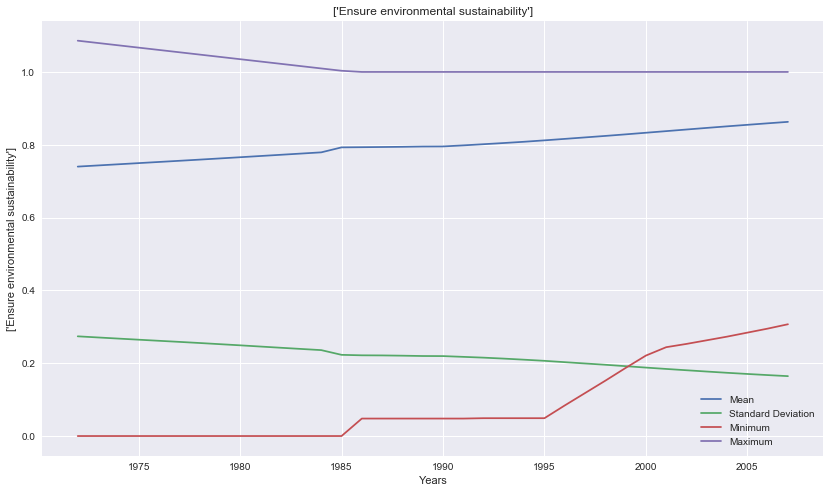

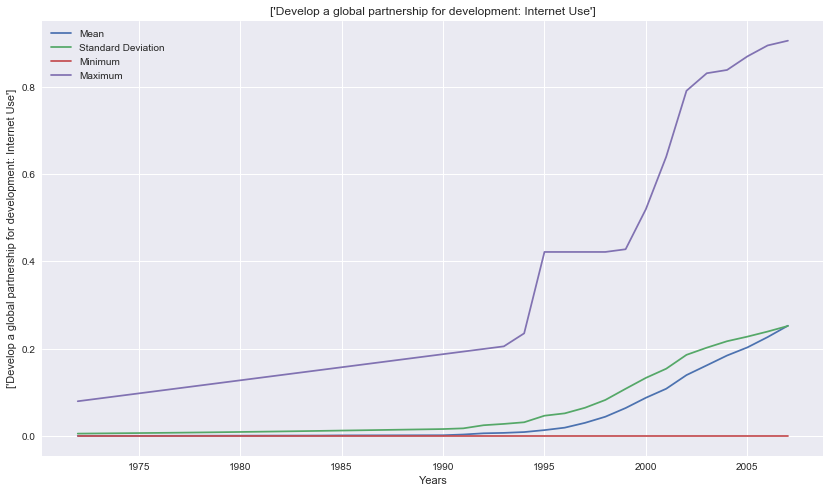

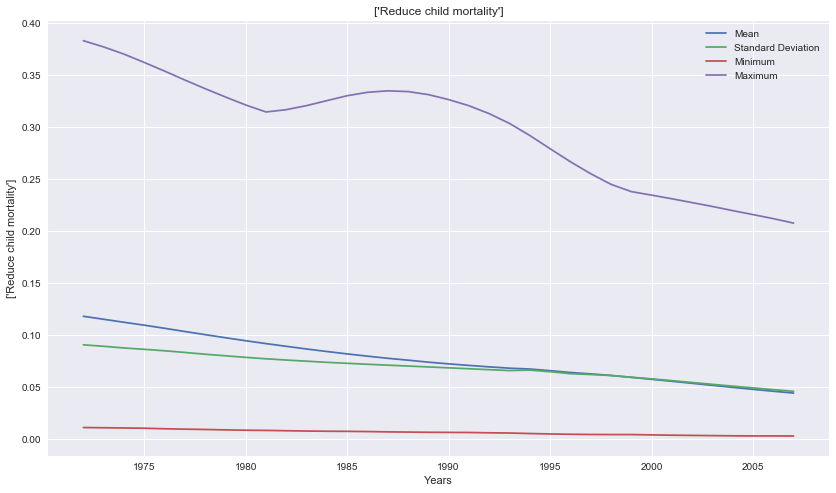

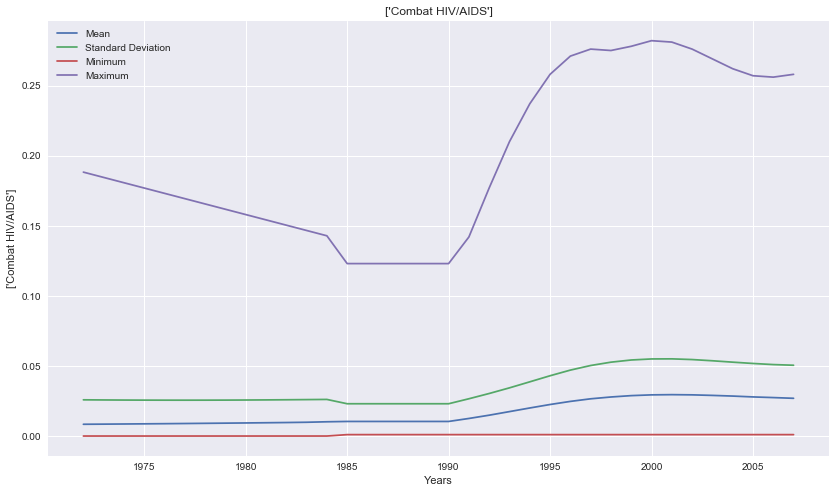

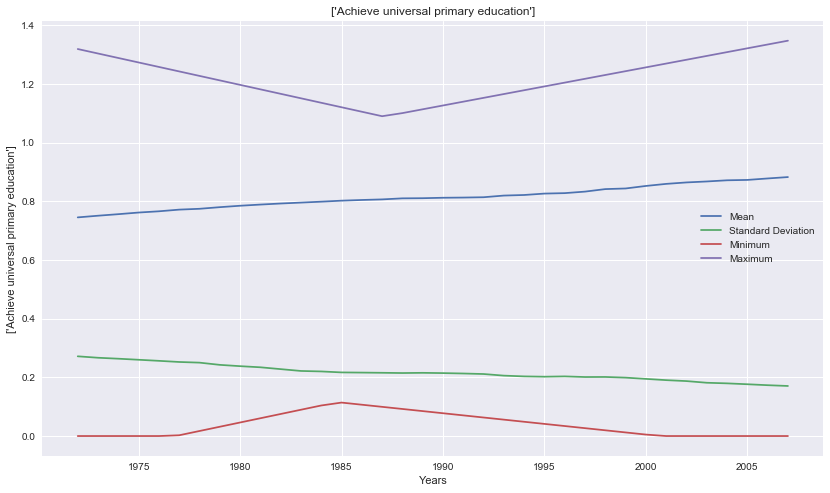

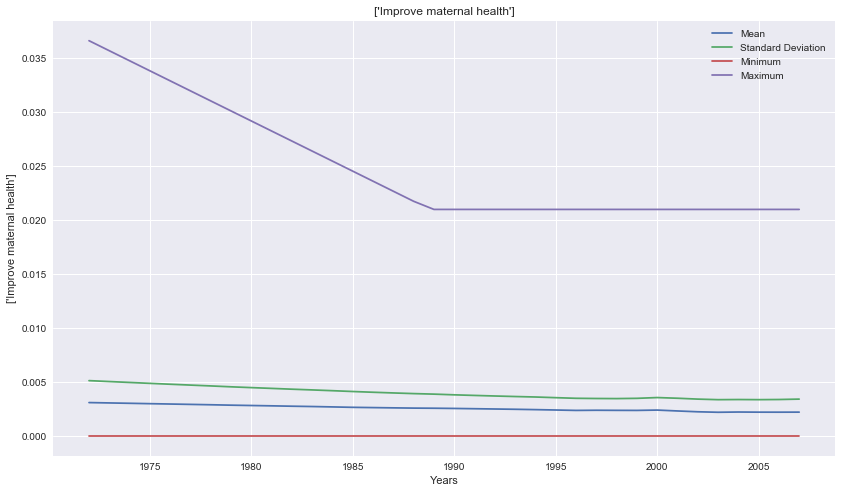

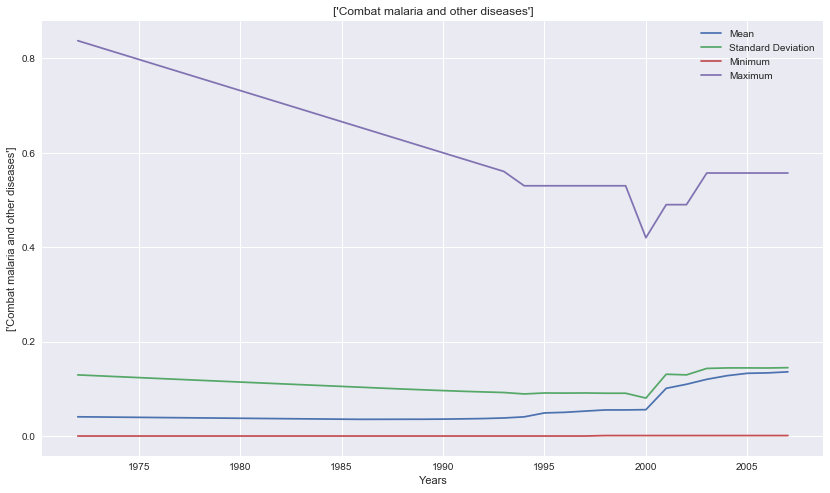

In [15]:
counts_agg = np.zeros(year_T - year_0 + 1)
#Make plots for means, standard deviations, minimums, maximums, and counts
#of each unique data series we care about predicting.
for code in training_data["Series Code"].loc[submission_labels.index].unique():
    plt.title(str( training_data["Series Name"][training_data['Series Code'] == code].unique()))
    temp = training_data[training_data['Series Code'] == code].describe()
    means = np.squeeze(temp[temp.columns.values].iloc[[1]].as_matrix())
    stds = np.squeeze(temp[temp.columns.values].iloc[[2]].as_matrix())
    counts = np.squeeze(temp[temp.columns.values].iloc[[0]].as_matrix())
    mini = np.squeeze(temp[temp.columns.values].iloc[[3]].as_matrix())
    maxi = np.squeeze(temp[temp.columns.values].iloc[[-1]].as_matrix())
    years = np.arange(year_0, year_T + 1)
    plt.plot(years, means, label = 'Mean')
    plt.plot(years, stds, label = 'Standard Deviation')
    plt.plot(years, mini, label = 'Minimum')
    plt.plot(years, maxi, label = 'Maximum')
    plt.ylabel(str( training_data["Series Name"][training_data['Series Code'] == code].unique()))
    plt.xlabel('Years')
    plt.legend(loc = 'best')
    plt.show()
    
#     plt.plot(years, counts, label = 'Counts')
#     plt.title('Counts')
#     plt.ylabel('Counts')
#     plt.xlabel('Years')
#     counts_agg += counts
    
#     plt.show()
    
# plt.plot(years, counts_agg, label = 'Counts in total')
# plt.title('Counts in total')
# plt.ylabel('Counts in total')
# plt.xlabel('Years')
# counts_agg += counts

# plt.show()


For Ensure environmental stability, the mean, max, min and standard deviation have all remained fairly constant. For internet use, all of these have increased except for minimum, whereas all metrics for reducing child mortality have decreased consistently over the years. There was a dip in the late 80s for the maximum countries in combating HIV/Aids, along with a brief increase in the minimums. We have a steady decrease until a plateau in 1990 with improving maternal health. The fight against malaria saw steady decrease through the decades until a brief surge in the late 90s. 

All in all, the time series after interpolation are rather disparate in their nature, but we don't see a lot of volatility with any of the series in the aggregate.

At this point, our training_data dataframe is in much better shape than it was initially, and we understand it much better. We understand how, in the aggregate, how the time series that we care about behave. We have added extra features to clarify the data further. 

Now it only remains to split these data up into appropriately sizes arrays to feed into a machine learning algorithm and make future predictions for the time series that we care about.

## On to prediction


The following are the algorithms we have covered this year, along with a justification for why I did not use any method except for linear regression for this round of machine learning methods.

nearest neighbor - This is an algorithm used for classification. My problem is a time series forecasting problem, has to do with predicting continuous data as opposed to binary or categorical data, and therefore nearest neighbor is not a valid approach.

naive Bayes - This is an algorithm used for classification. My problem is a time series forecasting problem, has to do with predicting continuous data as opposed to binary or categorical data, and therefore naive bayes is not a valid approach.

linear regression - This is a valid approach for my problem and I used it to predict values for 2008 and 2012 in my time series. The problem is that a linear regression is a fairly naive approach for time series forecasting, and I plan, after finishing the ARMA lab, on forecasting using AR, MA, ARIMA, or ARMA methods in a bid for better results. I will also try to predict using a long short-term memory network, which is a specific type of recurrent neural net.

ridge regression - The problem of forecasting using least squares is well-posed for my set of time series. Therefore, I needn't use ridge regression as this method is useful only when there isn't a unique solution to the problem.

logistic regression with and without regularization - Again, this is an algorithm used for classification. My problem is a time series forecasting problem, has to do with predicting continuous data as opposed to binary data, and therefore logistic regression with and without regularization is not a valid approach.

softmax regression with and without regularization - This is an algorithm used for classification. My problem is a time series forecasting problem, has to do with predicting continuous data as opposed to categorical data, and therefore softmax regression with and without regularization is not a valid approach.

linear discriminant analysis - This is an algorithm used for classification. My problem is a time series forecasting problem, has to do with predicting continuous data as opposed to categorical data, and therefore LDA is not a valid approach.

quadratic discriminant analysis - This is an algorithm used for classification. My problem is a time series forecasting problem, has to do with predicting continuous data as opposed to categorical data, and therefore QDA is not a valid approach.

Gaussian discriminant analysis - This is an algorithm used for classification. My problem is a time series forecasting problem, has to do with predicting continuous data as opposed to categorical data, and therefore GDA is not a valid approach.

mixture models with latent variables (train with EM) - This is an algorithm used for classification. My problem is a time series forecasting problem, has to do with predicting continuous data as opposed to categorical data, and therefore the approach of mixture models is not a valid one.

support vector machines and the kernel trick - This is an algorithm used for classification. My problem is a time series forecasting problem, has to do with predicting continuous data as opposed to categorical data, and therefore SVM is not a valid approach.

decision trees - This is an algorithm used for classification. My problem is a time series forecasting problem, has to do with predicting continuous data as opposed to categorical data, and therefore decision trees are not a valid approach. There have been several attempts to do time series with decision trees but this would be a project in and of itself, and so I will forgo it.

random forests - For the same reason as decision trees, I cannnot use random forests, since this is just an implementation of decision trees en masse.

gradient boosted trees - See last two explanations.

XGBoost - See last 3 explanations.

neural networks - I plan on using neural networks, but not the version of them we learned in class. I should have this done by next week. The version we used in class was a vanilla neural network, but I need a special kind of neural net called a recurrent neural net, and more specifically, a long short-term memory net, to do my forecasting. 

Kalman filter - I will use this in conjunction with ARMA models next week in order to get another set of predictions for my time series. 

AR, MA, ARMA, ARIMA time series models - Dr. Jarvis said that since we have yet to learn this method, we can implement it for next week.

hidden Markov models (more coming on this) - See last explanation.

Therefore, the only thing I will do to my data for forecasting will be to predict using least squares regression. I implement this below, and the results are clear. 


In [62]:
def predict_with_ols(time_series):
    """
    
    This function predicts outcomes for 2008 and 2012 based on time series from 1972 - 2007 using OLS 
    
    arguments:
        time_series:    time_series with missing data to be imputed
        
    returns:
        int_series:     the imputed time series
    
    """
    series = time_series.reset_index().drop('index', axis = 1).dropna()[:-5]
    x,y = np.array(series.index), np.array(series.values)
    x = x.flatten()
    y = y.astype(float)

    #Add a bias term
    x = sm.add_constant(x)

    #Fit OLS model to data
    model = sm.OLS(y, x)
    results = model.fit()
    
    #Come up with values with which to impute
    yhat = np.array([37, 41]) * results.params[1] + results.params[0]

    return yhat[0], yhat[1]

In [63]:
#Create new columns for prediction in both 2008, 2012
training_data.insert(36, generate_year_list(2008)[0], np.zeros(training_data.shape[0]))
training_data.insert(37, generate_year_list(2012)[0], np.zeros(training_data.shape[0]))


In [64]:
#Iterate through all rows and conduct OLS to predict values in 2008 and 2012
start = time.time()
for ix in tqdm(training_data.index):
    try:
        training_data.loc[ix,generate_year_list(2008)], training_data.loc[ix,generate_year_list(2012)] =\
        predict_with_ols(training_data.loc[ix])
    except:
        print("We've experienced an error. The following is the problem: \n Vector to be changed \
              = {}\n Index at which change needs to happen {}\n".format(training_data.loc[ix], ix))
time.time() - start

100%|██████████| 195402/195402 [14:02<00:00, 231.94it/s]


842.4545648097992

In [65]:
training_data

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],...,1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2012 [YR2012],Country Name,Series Code,Series Name
0,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,...,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,...,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,...,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...
4,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,...,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,Afghanistan,allsi.gen_pop,(%) Generosity of All Social Insurance
5,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,...,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,Afghanistan,allsp.gen_pop,(%) Generosity of All Social Protection
6,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,...,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,Afghanistan,allsa.gen_pop,(%) Generosity of All Social Safety Nets
8,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205

In [66]:
#training_data.to_csv('data/training_data_w_predictions.csv')

In [90]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        Parameters
        ----------
        F : ndarray of shape (n,n)
        The state transition model.
        Q : ndarray of shape (n,n)
        The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
        The observation model.
        R : ndarray of shape (m,m)
        The covariance matric for observation noise.
        u : ndarray of shape (n,)
        The control vector.
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        self.B = np.eye(4)

def evolve(self,x0,N):
    """
    Compute the first N states and observations generated by the Kalman -
    system.
    Parameters
    ----------
    x0 : ndarray of shape (n,)
    The initial state.
    N : integer
    The number of time steps to evolve.
    Returns
    -------
    states : ndarray of shape (n,N)
    States 0 through N-1, given by each column.
    obs : ndarray of shape (m,N)
    Observations 0 through N-1, given by each column.
    """
    m,n = np.shape(H)
    x = x0
    states = np.zeros((n,N))
    obs = np.zeros((m, N))
    for i in range(N):
        states[:, i] = x

        noise = np.random.multivariate_normal(np.zeros(4), self.Q)
        obs_noise = np.random.multivariate_normal(np.zeros(2), self. R)
        x = F.dot(x) + self.B.dot(self.u) + noise
        z = H.dot(x) + obs_noise
        obs[:, i] = z
    return states, obs

KalmanFilter.evolve = evolve

def estimate(self,x,P,z):
    """
    Compute the state estimates using the Kalman filter.
    If x and P correspond to time step k, then z is a sequence of
    observations starting at time step k+1.
    Parameters
    ----------
    x : ndarray of shape (n,)
    The initial state estimate.
    P : ndarray of shape (n,n)
    The initial error covariance matrix.
    z : ndarray of shape(m,N)
    Sequence of N observations (each column is an observation).
    Returns
    -------
    out : ndarray of shape (n,N)
    Sequence of state estimates (each column is an estimate).
    """
    n = len(x)
    N = len(z)
    z = z.reshape((1,N))
    m,N = z.shape

    out_x = []
    out_P = []
    for i in range(N):
        #Predict
        x = self.F.dot(x) + self.u
        out_x.append(x.flatten())
        P = self.F.dot(P).dot(self.F.T) + self.Q
        out_P.append(P)
        
        #Update
        y_tilde = z[:,i] - self.H.dot(x)
        S = self.H.dot(P).dot(self.H.T) + self.R
        K = P.dot(self.H.T.reshape((n,m))) * (1./S)
        x = x + K.dot(y_tilde)
        P = (np.eye(n) - K.dot(self.H.reshape((m,n)))).dot(P)
    return out_x, out_P

KalmanFilter.estimate = estimate

def predict(self,x,k):
    """
    Predict the next k states in the absence of observations.
    Parameters
    ----------
    x : ndarray of shape (n,)
    The current state estimate.
    k : integer
    The number of states to predict.
    Returns
    -------
    out : ndarray of shape (n,k)
    The next k predicted states.
    """
    out = np.zeros(k)
    for i in range(k):
        x = self.F.dot(x) + self.u
        out[i] = x
    return out

KalmanFilter.predict = predict

def rewind(self,x,k):
    """
    Predict the k states preceding the current state estimate x.
    Parameters
    ----------
    x : ndarray of shape (n,)
    The current state estimate.
    k : integer
    The number of preceding states to predict.
    Returns
    -------
    out : ndarray of shape (n,k)
    The k preceding predicted states.
    """
    n = len(x)
    out = np.zeros((n,k))
    out[:,- 1] = x
    for i in range(k - 1 ):
        x = np.linalg.inv(self.F).dot(x - self.u) 
        out[:, - ( i + 2)] = x
    return out

KalmanFilter.rewind = rewind

In [91]:
def arma_likelihood(time_series, phis=np.array([]), thetas=np.array([]), mu=0.,
    sigma=1.):
    """
    Return the log-likelihood of the ARMA model parameters, given the time
    series.
    
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
    The time series in question, z_t
    phis : ndarray of shape (p,)
    The phi parameters
    thetas : ndarray of shape (q,)
    The theta parameters
    mu : float
    The parameter mu
    sigma : float
    The standard deviation of the a_t random variables
    
    Returns
    -------
    log_likelihood : float
    The log-likelihood of the model
    """
    #Used for predict and update
    time_series_alt = time_series - mu
    
    n = len(time_series)
    p = len(phis)
    q = len(thetas)
    r = np.maximum(p, q+1)
    F = np.zeros((r,r))
    if p >= r:
        F[0] = phis[:r]
    else:
        F[0][:p] = phis
    F[1:, :-1] = np.eye(r-1)
    
    
    H = np.zeros(r)
    H[0] = 1
    if q < r-1:
        H[1:q + 1] = thetas
    else:
        H[1:] = thetas[:r-1]
    
    Q = np.zeros(((r,r)))
    Q[0,0] = sigma ** 2
    
    
    u = np.zeros(r)
    
    R = np.zeros((1, 1))
    kalman = KalmanFilter(  F, Q, H, R, u )
    
    x0 = np.zeros(r)
    P = np.linalg.inv(np.eye(r**2) - np.kron(F,F)).dot(Q.flatten())
    P = P.reshape((r,r))
    x_hat, P_hat = kalman.estimate(x0, P, time_series_alt)
    likelihood = 0
    for i in range(len(x_hat)):
        mean = H.dot(x_hat[i]) + mu
        std = np.sqrt(H.dot(P_hat[i]).dot(H.T))
        likelihood += np.log(norm.pdf(time_series[i],\
                loc = mean,\
                scale = std))
    return float(likelihood)

In [100]:
def arma_fit(time_series):
    """
    Return the ARMA model that minimizes AICc for the given time series,
    subject to p,q <= 3.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
    The time series in question, z_t
    
    Returns
    -------
    phis : ndarray of shape (p,)
    The phi parameters
    thetas : ndarray of shape (q,)
    The theta parameters
    mu : float
    The parameter mu
    sigma : float
    The standard deviation of the a_t random variables
    """
    ps = [1, 2, 3]
    qs = [1, 2, 3]
    
    AIC_list = []
    sol_list = []
    p_list = []
    q_list = []
    for p, q in itertools.product(ps, qs):
        # assume p, q, and time_series are defined
        def f(x): # x contains the phis, thetas, mu, and sigma
            return -1*arma_likelihood(time_series, phis=x[:p], \
                    thetas=x[p:p+q],mu=x[-2],sigma=x[-1])
        
        # create initial point
        x0 = np.zeros(p+q+2)
        x0[-2] = time_series.mean()
        x0[-1] = time_series.std()
        sol = op.fmin(f,x0,maxiter=10000, maxfun=10000, disp = False)
        k = p + q + 2
        n = len(time_series)
        AIC = 2*k*(1+ (k+1)/(n-k))-2*np.exp(-f(sol))
        AIC_list.append(AIC)
        sol_list.append(sol)
        p_list.append(p)
        q_list.append(q)
#         p_list.append(sol)
        
    min_idx = np.argmin(np.array(AIC_list))
    best_params = sol_list[min_idx]
    best_p = p_list[min_idx]
    best_q = q_list[min_idx]
    p = best_p
    q = best_q
    best_phis = best_params[:best_p]
    best_thetas = best_params[p:p+q]
    best_mu = best_params[-2]
    best_sigma = best_params[-1]
    return best_phis, best_thetas, best_mu, best_sigma

In [93]:
def arma_forecast(time_series, phis=np.array([]), thetas=np.array([]), mu=0.,
    sigma=1., future_periods=20):
    """
    Return forecasts for a time series modeled with the given ARMA model.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
    The time series in question, z_t
    phis : ndarray of shape (p,)
    The phi parameters
    thetas : ndarray of shape (q,)
    The theta parameters
    mu : float
    The parameter mu
    sigma : float
    The standard deviation of the a_t random variables
    future_periods : int
    The number of future periods to return
    Returns
    -------
    e_vals : ndarray of shape (future_periods,)
    The expected values of z for times n+1, ..., n+future_periods
    sigs : ndarray of shape (future_periods,)
    The standard deviations of z for times n+1, ..., n+future_periods
    """
    time_series_alt = time_series - mu
    
    n = len(time_series_alt)
    p = len(phis)
    q = len(thetas)
    r = np.maximum(p, q+1)
    
    F = np.zeros((r,r))
    if p >= r:
        F[0] = phis[:r]
    else:
        F[0][:p] = phis
    F[1:, :-1] = np.eye(r-1)
    
    
    H = np.zeros(r)
    H[0] = 1
    if q < r-1:
        H[1:q + 1] = thetas
    else:
        H[1:] = thetas[:r-1]
    
    Q = np.zeros(((r,r)))
    Q[0,0] = sigma ** 2
    u = np.zeros(r)
    
    R = np.zeros((1, 1))
    kalman = KalmanFilter(  F, Q, H, R, u )

    
    x0 = np.zeros(r)
    P = np.linalg.inv(np.eye(r**2) - np.kron(F,F)).dot(Q.flatten())
    P = P.reshape((r,r))
    x, P = kalman.estimate(x0, P, time_series_alt)
    x = x[-1]
    P = P[-1]
    
    x_list = []
    P_list = []
    e_vals = []
    sigs = []

    for i in range(future_periods):
        x = F.dot(x)
        P = F.dot(P).dot(F.T) + Q
        x_list.append(x)
        P_list.append(P)
        mean = H.dot(x) + mu
        std = np.sqrt(H.dot(P).dot(H.T))
        
        e_vals = [H.dot(np.array(x_)) + mu for x_ in x_list]
        sigs = [np.sqrt(H.dot(np.array(P_)).dot(H.T)) for P_ in P_list]
    return e_vals, sigs

In [94]:
# best_params = arma_fit(time_series)

# phis = best_params[0]
# thetas = best_params[1]
# mu = best_params[2]
# sigma = best_params[3]
# p = len(phis)
# q = len(thetas)

# e_vals, sigs = arma_forecast(time_series_a, phis, thetas, mu, sigma, 5)
# # e_vals, sigs = np.array(e_vals), np.array(sigs)

In [95]:
training_data

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],...,1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],2008 [YR2008],2012 [YR2012],Country Name,Series Code,Series Name
0,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,...,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,3.769214e+00,0.0,0.0,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,...,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,7.027746e+00,0.0,0.0,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,...,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,8.244887e+00,0.0,0.0,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...
4,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,...,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,1.293310e+01,0.0,0.0,Afghanistan,allsi.gen_pop,(%) Generosity of All Social Insurance
5,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,...,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,1.899681e+01,0.0,0.0,Afghanistan,allsp.gen_pop,(%) Generosity of All Social Protection
6,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,...,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,2.242306e+01,0.0,0.0,Afghanistan,allsa.gen_pop,(%) Generosity of All Social Safety Nets
8,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e-01,5.205600e

In [101]:
def predict_with_arma(time_series):
    """
    
    This function predicts outcomes for 2008 and 2012 based on time series from 1972 - 2007 using OLS 
    
    arguments:
        time_series:    time_series with missing data to be imputed
        
    returns:
        int_series:     the imputed time series
    
    """
    series = time_series.reset_index().drop('index', axis = 1).dropna()[:-5]
    y = np.array(series.values)
    y = y.flatten()
    time_series = y
    
    best_params = arma_fit(time_series)
#     print ('BEST PARAMS', best_params)
    
    phis = best_params[0]
    thetas = best_params[1]
    mu = best_params[2]
    sigma = best_params[3]
   
    e_vals, sigs = arma_forecast(time_series, phis, thetas, mu, sigma, 5)
    e_vals, sigs = np.array(e_vals), np.array(sigs)

    
    return e_vals[0], e_vals[-1]

In [102]:
#Create new columns for prediction in both 2008, 2012
training_data.insert(36, generate_year_list(2008)[0], np.zeros(training_data.shape[0]))
training_data.insert(37, generate_year_list(2012)[0], np.zeros(training_data.shape[0]))


ValueError: cannot insert 2008 [YR2008], already exists

In [107]:
#Iterate through all submission rows and conduct arma analysis to predict values in 2008 and 2012
start = time.time()
for ix in tqdm(submission_labels.index):
#     training_data.loc[ix,generate_year_list(2008)], training_data.loc[ix,generate_year_list(2012)] =\
#     predict_with_arma(training_data.loc[ix])
    try:
        training_data.loc[ix,generate_year_list(2008)], training_data.loc[ix,generate_year_list(2012)] =\
        predict_with_arma(training_data.loc[ix])
    except:
        print("We've experienced an error. The following is the problem: \n Vector to be changed \
              = {}\n Index at which change needs to happen {}\n".format(training_data.loc[ix], ix))
    
time.time() - start


  0%|          | 0/737 [00:00<?, ?it/s]/Users/crytting/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in sqrt
/Users/crytting/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:64: RuntimeWarning: divide by zero encountered in log

  8%|▊         | 61/737 [47:56<8:12:24, 43.71s/it] /Users/crytting/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in sqrt
/Users/crytting/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:77: RuntimeWarning: invalid value encountered in sqrt
 23%|██▎       | 170/737 [2:12:16<6:05:58, 38.73s/it]  /Users/crytting/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:93: RuntimeWarning: divide by zero encountered in true_divide
/Users/crytting/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dty

34453.5452837944

In [108]:
training_data.to_csv('data/training_data_w_predictions_arma.csv')

In [120]:
# For submissions: 
# training_data.loc[submission_labels.index, generate_year_list([2008,2012])].to_csv('submission_arma.csv')
# submission1 = pd.read_csv('submission.csv', index_col = 0)

# Manipulate submission

# submission1.to_csv('submission_avg_12.csv')


## Sources

[1] https://www.drivendata.org/competitions/1/page/3/

[2] J. Schmidhuber and D. Wierstra and F. J. Gomez. Evolino: Hybrid Neuroevolution / Optimal Linear Search for Sequence Learning. Proceedings of the 19th International Joint Conference on Artificial Intelligence (IJCAI), Edinburgh, pp. 853–858, 2005.

[3] http://www.datasciencecentral.com/profiles/blogs/recurrent-neural-networks-time-series-data-and-iot-part-one

